In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree,classificationSummary, regressionSummary


In [7]:
import dmba
# Load the data
car_df = dmba.load_data('ToyotaCorolla.csv')

# Select the required columns
columns = ['Price', 'Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic',
          'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period',
          'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows',
          'Sport_Model', 'Tow_Bar']

car_df = car_df[columns]

# Convert Fuel_Type to dummy variables
car_df = pd.get_dummies(car_df, drop_first=True)

outcome = 'Price'
predictors = list(car_df.columns)
predictors.remove(outcome)

#Make sure that the result is as expected
car_df.head()

,Price,Age_08_04,KM,HP,Automatic,Doors,Quarterly_Tax,Mfr_Guarantee,Guarantee_Period,Airco,Automatic_airco,CD_Player,Powered_Windows,Sport_Model,Tow_Bar,Fuel_Type_Diesel,Fuel_Type_Petrol
0,13500,23,46986,90,0,3,210,0,3,0,0,0,1,0,0,True,False
1,13750,23,72937,90,0,3,210,0,3,1,0,1,0,0,0,True,False
2,13950,24,41711,90,0,3,210,1,3,0,0,0,0,0,0,True,False
3,14950,26,48000,90,0,3,210,1,3,0,0,0,0,0,0,True,False
4,13750,30,38500,90,0,3,210,1,3,1,0,0,1,0,0,True,False


In [16]:
# seperate out predictors and outcome variable
X = car_df[predictors]
y = car_df[outcome]

#partition the data into training (60%) and validation (40%). Set random_state=1 for reproducility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=1)
print("Training set:")
print(X_train.shape)


print("\nValidation set:")
print(X_val.shape)


Training set:
(861, 16)

Validation set:
(575, 16)


In [19]:
# setting random state will ensure that the same tree is produced every time
deepTree = DecisionTreeRegressor(random_state=1)
deepTree.fit(X_train, y_train)

print('Tree has {} nodes'.format(deepTree.tree_.node_count))

Tree has 1485 nodes


In [21]:
# Variable importance
importance = pd.DataFrame({'features': X_train.columns,
                          'importance': deepTree.feature_importances_})
importance.sort_values(by='importance', ascending=False)

,features,importance
0,Age_08_04,0.844867
2,HP,0.053789
1,KM,0.049601
9,Automatic_airco,0.013358
5,Quarterly_Tax,0.006769
11,Powered_Windows,0.005221
4,Doors,0.004864
8,Airco,0.004727
12,Sport_Model,0.004459
6,Mfr_Guarantee,0.003714


In [23]:
#error report for training and validation sets
print('training set:')
regressionSummary(y_train, deepTree.predict(X_train))
print('\nvalidation set:')
regressionSummary(y_val, deepTree.predict(X_val))

training set:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000

validation set:

Regression statistics

                      Mean Error (ME) : 76.6557
       Root Mean Squared Error (RMSE) : 1492.3365
            Mean Absolute Error (MAE) : 1152.4852
          Mean Percentage Error (MPE) : -0.3363
Mean Absolute Percentage Error (MAPE) : 11.3783


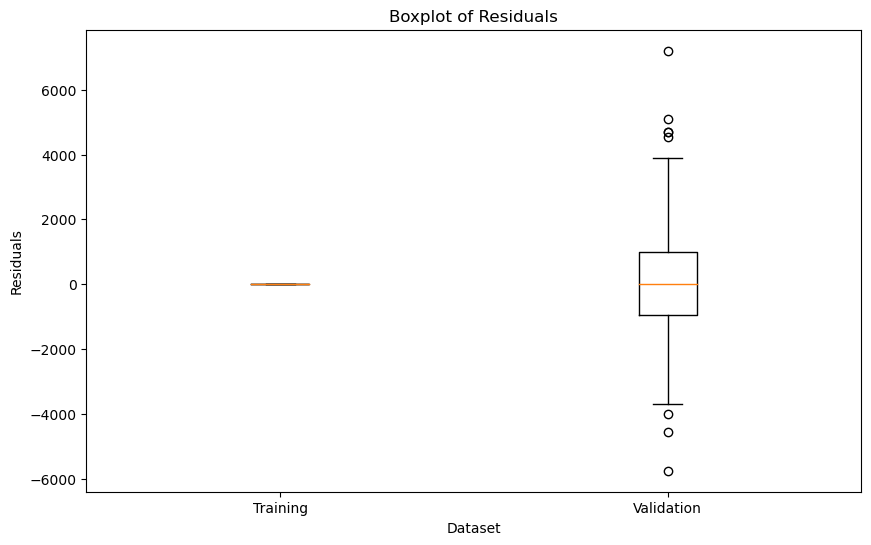

In [24]:
import matplotlib.pyplot as plt

# Calculate residuals for training set
train_residuals = y_train - deepTree.predict(X_train)

# Calculate residuals for validation set
val_residuals = y_val - deepTree.predict(X_val)

# Create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot([train_residuals, val_residuals], labels=['Training', 'Validation'])
plt.title('Boxplot of Residuals')
plt.xlabel('Dataset')
plt.ylabel('Residuals')
plt.show()


In [25]:
# before doing full grid search, try a tree of depth = 5
# smaller tree
shallowTree = DecisionTreeRegressor(max_depth=5)
shallowTree.fit(X_train, y_train)
print('Tree has {} nodes'.format(shallowTree.tree_.node_count))

Tree has 59 nodes


In [26]:
# error report for training and validation sets
print('training set:')
regressionSummary(y_train, shallowTree.predict(X_train))
print('\nvalidation set:')
regressionSummary(y_val, shallowTree.predict(X_val))

training set:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1028.0279
            Mean Absolute Error (MAE) : 773.2770
          Mean Percentage Error (MPE) : -1.0039
Mean Absolute Percentage Error (MAPE) : 7.6715

validation set:

Regression statistics

                      Mean Error (ME) : 52.8857
       Root Mean Squared Error (RMSE) : 1160.9679
            Mean Absolute Error (MAE) : 914.1468
          Mean Percentage Error (MPE) : -0.6477
Mean Absolute Percentage Error (MAPE) : 9.2441


In [29]:
#user grid search to find optimized tree
param_grid = {
    'max_depth':[5, 10, 15, 20, 25],
    'min_impurity_decrease':[0, 0.0001, 0.005, 0.01],
    'min_samples_split': [10, 20, 30, 40, 50],
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1),
                         param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth':[5, 6, 7, 8, 9, 10, 11, 12, 13],
    'min_impurity_decrease': [0, 0.0001, 0.002, 0.003, 0.004, 0.005,
                             0.006, 0.007],
    'min_samples_split':[17, 18, 19, 20, 21, 22, 23],
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1),
                         param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved parameters: ', gridSearch.best_params_)

optRegTree = gridSearch.best_estimator_

importanceRT = pd.DataFrame({'features': X_train.columns,
                            'importance': deepTree.feature_importances_})

print('Tree has {} nodes'.format(optRegTree.tree_.node_count))

Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 21}
Tree has 61 nodes


In [31]:
#error report for training and validation sets
print('training set:')
regressionSummary(y_train, optRegTree.predict(X_train))
print('\nvalidation set:')
regressionSummary(y_val, optRegTree.predict(X_val))

training set:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1100.9381
            Mean Absolute Error (MAE) : 799.4101
          Mean Percentage Error (MPE) : -1.0081
Mean Absolute Percentage Error (MAPE) : 7.6852

validation set:

Regression statistics

                      Mean Error (ME) : 23.7040
       Root Mean Squared Error (RMSE) : 1240.2015
            Mean Absolute Error (MAE) : 950.0088
          Mean Percentage Error (MPE) : -1.0616
Mean Absolute Percentage Error (MAPE) : 9.5168
